In [1]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner")
if "/home/jogi/.local/lib/python2.7/site-packages" in sys.path:
    sys.path.remove("/home/jogi/.local/lib/python2.7/site-packages")

import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict


from utils.experiment import Experiment
from utils.common import get_model, create_def_argparser, create_logger, softmax
from utils.common import compute_total_steps, get_evaluation_step_loss
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, plot_dist_optimization_steps
from utils.plots import plot_actsb_qts, plot_image_map_data, plot_image_map_losses
from utils.plots import plot_loss_over_tsteps, plot_halting_step_stats_with_loss, plot_loss_versus_halting_step
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.regression import RegressionFunction, L2LQuadratic, RegressionWithStudentT
from utils.helper import tensor_and, tensor_any
from utils.batch_handler import ACTBatchHandler
from utils.epoch import Epoch, halting_step_stats
from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.sb_act_optimizer import StickBreakingACTBaseModel

from utils.regression import RegressionFunction, L2LQuadratic, neg_log_likelihood_loss, RosenBrock
from utils.regression import RegressionWithStudentT

%load_ext autoreload
%autoreload 2

In [2]:
expers_to_load = [ # BASELINE on Regression T
                  (False, "run_20170930_15_17_50_metaV1_45ep_25ops_lr4e05"), # 25
                  (False, "run_20170930_12_21_10_metaV1_50ep_50ops_lr4e05"), # 50 steps
                  (False, "run_20171001_12_01_01_metaV1_30ep_100ops_lr4e05"), # 100 steps
                  # M-ACT V1 model regression T
                  (True, "run_20171002_17_11_24_meta_actV1_45ep_tau0.0008_lr5e05"), # used
                  (True, "run_20171002_23_12_29_meta_actV1_45ep_tau0.0018_lr5e05"),  # used best
                  (True, "run_20171003_09_26_07_meta_actV1_45ep_tau0.009_lr5e05"),  # used
                  ]



In [3]:
## IMPORTANT ---- NUMBER OF STEPS FOR TEST EVALUATION
MAX_EVAL_STEPS = 35

without_models = False

path_ext = None
experiments = []
models = []
new_experiments = []
explogger = None
m = 0
if 'logger' in vars() or 'logger' in globals():
    pass
else:
    logger = create_logger(exper=None, file_handler=True, output_dir="/home/jogi/git/repository/meta_learner/logs")

for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        
        if path_ext is not None:
            exp_file_path = os.path.join(path_ext, exp_path[1])
        else:
            exp_file_path = exp_path[1]
            
        exp = Experiment.load(exp_file_path, do_log=True, meta_logger=logger)
            
        if "act" in exp.args.model:
            print("{} Loading model {} (q-prob {:.2f}) / {}".format(m, exp.args.model, 
                                                                    exp.config.ptT_shape_param,
                                                                    exp.args.log_dir))
        else:
            print("{} Loading model {} / {}".format(m, exp.args.model, exp.args.log_dir))
        
        experiments.append(exp)
        m += 1
        if not without_models:
            num_inputs = 1
            if exp.args.problem == 'mlp':
                num_inputs = 3
            models.append(get_model(exp, num_inputs, retrain=True))
        new_experiments.append(Experiment(exp.args, exp.config, set_seed=True))
        new_experiments[-1].batch_handler_class = experiments[-1].batch_handler_class
        new_experiments[-1].output_dir = experiments[-1].output_dir
        new_experiments[-1].reset_val_stats()
        new_experiments[-1].meta_logger = logger
        new_experiments[-1].validation_handler_class = experiments[-1].validation_handler_class
        new_experiments[-1].training_horizon = experiments[-1].config.T
        new_experiments[-1].avg_num_opt_steps = experiments[-1].avg_num_opt_steps

INFO - created local logger for experiment with model meta_actV1_regression_T_tau0.0008
INFO - INFO - loaded existing model from file logs/run_20171002_17_11_24_meta_actV1_45ep_tau0.0008_lr5e05/meta_actV1_regression_T_tau0.0008.pkl
INFO - Note: StickBreakingACTBaseModel is running on GPU
INFO - ['linear_in.weight', 'linear_in.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'theta_linear_out.weight', 'rho_linear_out.weight', 'rho_linear_out.bias']
INFO - created local logger for experiment with model meta_actV1_regression_T_tau0.0018
INFO - INFO - loaded existing model from file logs/run_20171002_23_12_29_meta_actV1_45ep_tau0.0018_lr5e05/meta_actV1_regression_T_tau0.0018.pkl
INFO - Note: StickBreakingACTBaseModel is running on GPU
INFO - ['linear_in.weight', 'linear_in.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h

0 Loading model meta_actV1_regression_T_tau0.0008 (q-prob 0.90) / run_20171002_17_11_24_meta_actV1_45ep_tau0.0008_lr5e05
1 Loading model meta_actV1_regression_T_tau0.0018 (q-prob 0.90) / run_20171002_23_12_29_meta_actV1_45ep_tau0.0018_lr5e05
2 Loading model meta_actV1_regression_T_tau0.009 (q-prob 0.90) / run_20171003_09_26_07_meta_actV1_45ep_tau0.009_lr5e05


In [4]:
# del new_experiments
new_experiments = []
unrolled_steps=200
num_of_funcs = 10000

if 'logger' in vars() or 'logger' in globals():
    pass
else:
    logger = create_logger(exper=None, file_handler=True, output_dir="/home/jogi/git/repository/meta_learner/logs")

for exper in expers_to_load:
    if exper[0]:
        
        path_to_exp = exper[1] + "/" + "exp_eval_stats_" + str(num_of_funcs) + "_" + str(unrolled_steps) +"steps.dll"
        print("Loading experiment {} / path {}".format(exper[1], path_to_exp))
        new_experiments.append(Experiment.load(path_to_exp=path_to_exp,
                                               full_path=True))
        if new_experiments[-1].meta_logger is None:
            new_experiments[-1].meta_logger = logger
print("Ready")

Loading experiment run_20171002_17_11_24_meta_actV1_45ep_tau0.0008_lr5e05 / path run_20171002_17_11_24_meta_actV1_45ep_tau0.0008_lr5e05/exp_eval_stats_10000_200steps.dll
Loading experiment run_20171002_23_12_29_meta_actV1_45ep_tau0.0018_lr5e05 / path run_20171002_23_12_29_meta_actV1_45ep_tau0.0018_lr5e05/exp_eval_stats_10000_200steps.dll
Loading experiment run_20171003_09_26_07_meta_actV1_45ep_tau0.009_lr5e05 / path run_20171003_09_26_07_meta_actV1_45ep_tau0.009_lr5e05/exp_eval_stats_10000_200steps.dll
Ready


In [4]:
with open("data/test_regression_T_10000_10_1.0_10.dll", 'rb') as f:
     test_funcs = dill.load(f)
print("Ready")

Ready


INFO - Successfully saved fig figures/10regT_MACT_100_200.png


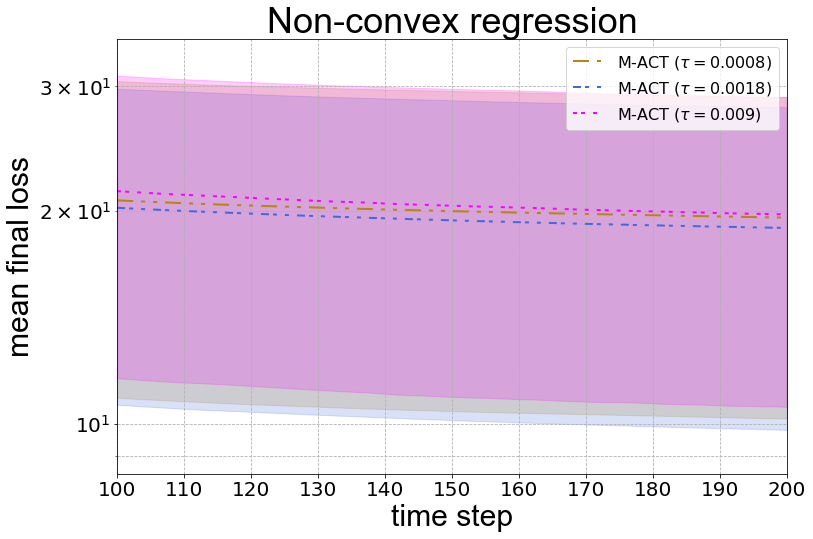

In [6]:
#new_exp_select = [new_experiments[0], new_experiments[1], new_experiments[2], new_experiments[4],
#                 new_experiments[6]] 
#, new_experiments[4]] 

part = 2
if part == 1:
    min_step = 0
    max_step = 100
    y_lim = [10,60 ]
    log_scale  = False
elif part == 2:
    min_step = 100
    max_step = 200
    log_scale = True
    y_lim=[8.5, 35]
else:
    log_scale = True
    min_step = 0
    max_step = 100
    y_lim=[8.5, 56]

best_val_runs, lowest_value = plot_loss_over_tsteps(new_experiments, do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              fig_name="10regT_MACT_" + str(min_step) + "_" + str(max_step), 
                                              loss_type="loss",
                                              min_step=min_step,
                                              max_step=max_step,
                                              sort_exper="Non-convex regression",
                                              log_scale=log_scale,
                                              y_lim=y_lim,
                                              with_stddev=True,
                                              runID=None)

In [ ]:
# eval_new_val_expers = [new_experiments[0], new_experiments[3]] #, new_experiments[5]]

best_val_runs, lowest_value = plot_val_result(new_experiments, 
                                              do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              loss_type="loss",
                                              fig_name="expv5_val_results_1000_loss_10ops")

In [ ]:
# eval_expers = new_exp_only = [experiments[0], experiments[1], experiments[2]]
plot_parm_loss_steps(experiments, num_of_plots=4, do_show=True, 
                     do_save=False, loss_type="loss", log_scale=False, max_step=20,
                    fig_name="metaV2_val_loss_during_training")

In [26]:
exp_idx = 2
model = models[exp_idx]

max_steps = 200
# new_experiments[exp_idx].model_path

new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].type_prior = "geometric"


epoch_obj = Epoch()
epoch_obj.start(new_experiments[exp_idx])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))
new_experiments[exp_idx].eval(epoch_obj, model, functions=test_funcs, save_run=None, save_model=False,
                              test_time=True)
print("End....")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

INFO - Epoch: 400 - Evaluating 10000 test functions


Validating model meta_actV1_regression_T_tau0.009 with q-prob 0.900


INFO - Epoch: 400 - evaluation result - time step losses
INFO - [ 56.32   42.813  37.609  35.874  34.212  32.619  31.591  31.126  30.959
  30.854  30.666  30.359  29.947  29.487  29.038  28.631  28.277  27.957
  27.655  27.363  27.083  26.814  26.561  26.328  26.116  25.918  25.727
  25.549  25.383  25.23   25.087  24.954  24.827  24.704  24.586  24.473
  24.367  24.264  24.168  24.077  23.991  23.908  23.83   23.753  23.679
  23.607  23.538  23.472  23.412  23.355  23.297  23.239  23.179  23.121
  23.062  23.007  22.955  22.905  22.855  22.806  22.756  22.707  22.66
  22.614  22.568  22.521  22.471  22.425  22.378  22.337  22.296  22.262
  22.226  22.189  22.151  22.113  22.074  22.034  21.994  21.956  21.922
  21.887  21.856  21.823  21.794  21.761  21.73   21.701  21.674  21.646
  21.617  21.586  21.558  21.525  21.494  21.466  21.439  21.412  21.386
  21.359  21.33   21.301  21.271  21.244  21.217  21.191  21.163  21.137
  21.114  21.092  21.072  21.053  21.034  21.013  20.992  20.

End....


In [9]:
X = np.vstack(new_experiments[2].val_stats["halt_step_funcs"].values())

In [ ]:

exp_idx = 3
max_steps = 200
new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].config.qt_threshold = 0.95
new_experiments[exp_idx].reset_val_stats()
if new_experiments[exp_idx].meta_logger is None:
    new_experiments[exp_idx].meta_logger = logger
# the same object for the validation data
model = models[exp_idx]
model.opt_step_hist_val = np.zeros(new_experiments[exp_idx].config.max_val_opt_steps)
model.qt_hist_val = OrderedDict([(i, np.zeros(i)) 
                                 for i in np.arange(1, new_experiments[exp_idx].config.max_val_opt_steps + 1)])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))

if "act" in model.name:
    model.init_qt_statistics(new_experiments[exp_idx].config)

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=test_funcs, 
                   max_steps=max_steps, verbose=False, plot_func=False, show_plot=False, save_plot=False,
                   num_of_plots=5, save_model=False, save_qt_prob_funcs=False, 
                   save_run="exp_eval_stats_10000_"+str(max_steps) + "steps")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

In [ ]:
plot_qt_probs(new_experiments[2], data_set="val", save=True, show=True, 
              plot_prior=False, height=20, width=20, add_info=True)

In [ ]:
from utils.plots import create_exper_label
num_of_plots = 13
T0 = 23
fig = plt.figure(figsize=(8, 25))

for i in range(1, num_of_plots+1):
    T = T0+i
    index = np.arange(1, T+1).astype(int)
    qt = exper.val_stats["qt_hist"][30][T]
    ax1 = plt.subplot(num_of_plots, 1, i)
    plt.bar(index, qt, 0.3, label="q(t|{})".format(T))
    ax1.legend(loc="best")
    
fig_name = "_" + "val" + "_" + create_exper_label(exper)
fig_name = os.path.join(exper.output_dir, config.qt_dist_prefix + fig_name + ".png")
plt.savefig(fig_name, bbox_inches='tight')
plt.close()

INFO - Successfully saved fig logs/run_20170814_17_04_25_metaV1_50ep_100ops_lr3e05/loss_metaV1_50ep_100ops_21:43:29.png


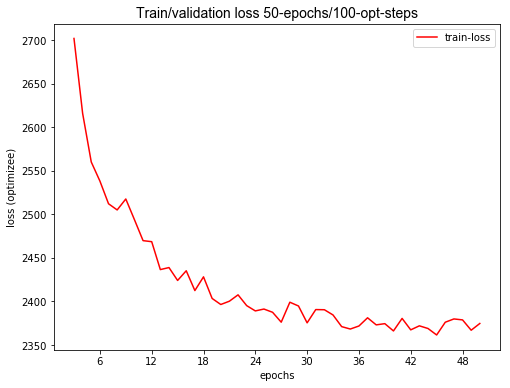

In [41]:
loss_plot(experiments[0], show=True, save=True, validation=False, only_val=False)

('Sum p(t) ', 0.99999999999999989)
INFO - Successfully saved fig logs/run_20171002_17_11_24_meta_actV1_45ep_tau0.0008_lr5e05/trajectory_weights_test_t0_0008.png


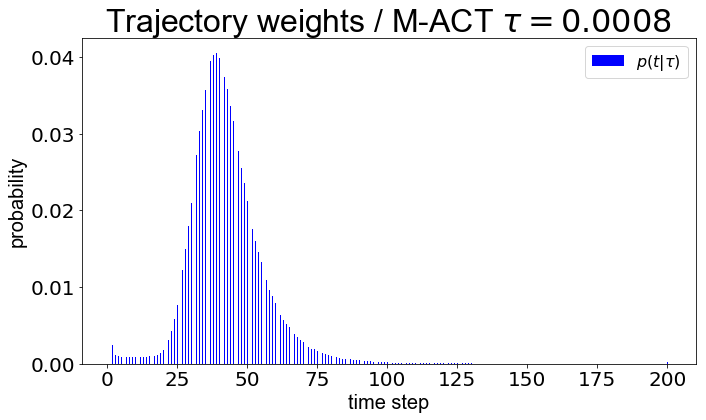

In [13]:
exper = new_experiments[0]
x_max = None
hyper_param = str.replace(str(exper.config.tau), '.', '_')
plot_actsb_qts(exper, data_set="eval", save=True, show=True, add_info=False, epoch=400, 
              fig_name="trajectory_weights_test" + "_t{}".format(hyper_param), 
              huge=True,
              p_title=r"Trajectory weights / M-ACT $\tau={}$".format(exper.config.tau),
              height=6, width=11, x_max=x_max)

INFO - Successfully saved fig logs/run_20171003_09_26_07_meta_actV1_45ep_tau0.009_lr5e05/test10000_halt_histogram.png


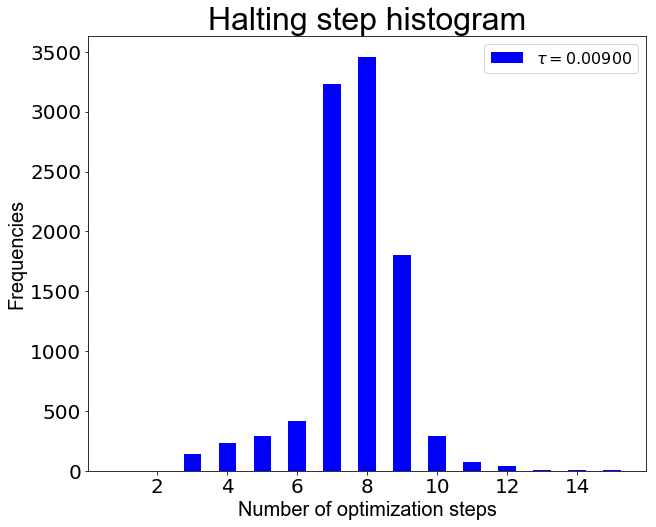

In [10]:
plot_dist_optimization_steps(new_experiments[2], data_set="eval", save=True, show=True, epoch=400, 
                            huge=True, xlimits=None, plot_title="Halting step histogram",
                            fig_name="test10000_halt_histogram")

INFO - Successfully saved fig logs/run_20171002_17_11_24_meta_actV1_45ep_tau0.0008_lr5e05/input_dependency_t0_0008.png


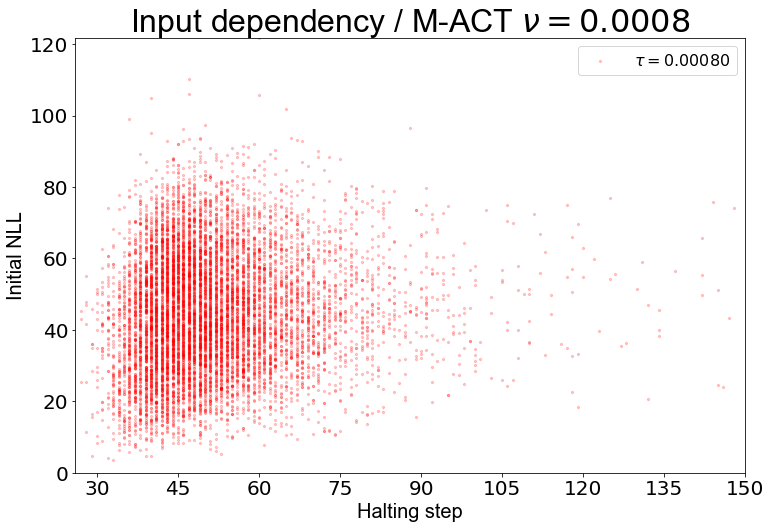

Mean 51.4986, Std 13.5532209471, Median 49, Total steps 514986


In [16]:

exper = new_experiments[0]
x_max = 150
hyper_param = str.replace(str(exper.config.tau), '.', '_')
plot_loss_versus_halting_step(exper, epoch=400, do_show=True, do_save=True, x_max=x_max,
                              p_title="Input dependency / M-ACT" + r" $\nu={}$".format(exper.config.tau), 
                              huge=True, log_scale=False,
                              fig_name="input_dependency" + "_t{}".format(hyper_param))

[ 20  40  60  80 100]
INFO - Successfully saved fig logs/run_20171003_09_26_07_meta_actV1_45ep_tau0.009_lr5e05/10dregT_mact_st_losses_t0_009.png


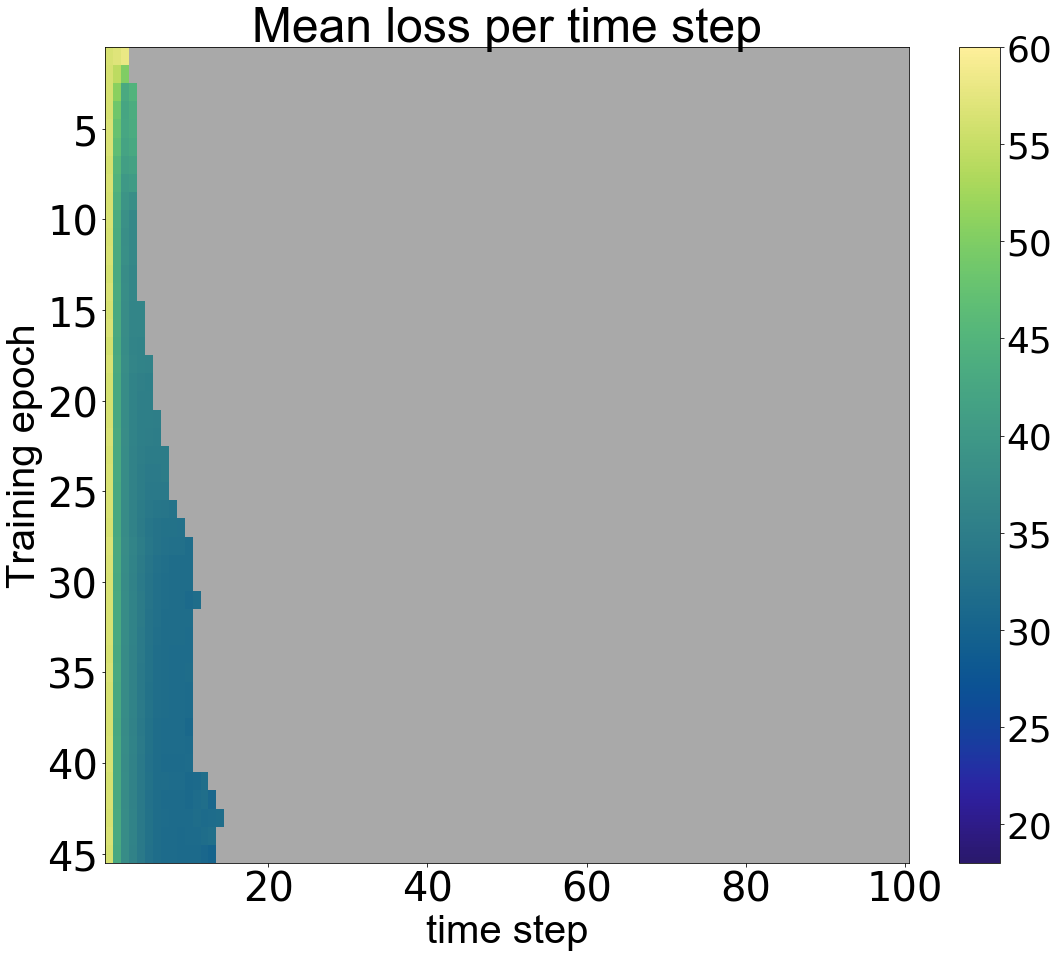

In [6]:

exper = experiments[2]
max_epoch = None
hyper_param = str.replace(str(exper.config.tau), '.', '_')
plot_image_map_losses(exper, fig_name="10dregT_mact_st_losses" + "_t{}".format(hyper_param),
                      do_save=True, do_show=True, 
                      max_epoch=max_epoch, max_time_step=None, 
                      fig_title="Mean loss per time step", 
                      scale= [18,60], huge=True)

[ 20  40  60  80 100]
INFO - Successfully saved fig logs/run_20171002_17_11_24_meta_actV1_45ep_tau0.0008_lr5e05/10dregT_mact_train_halt_dist_t0_0008.png


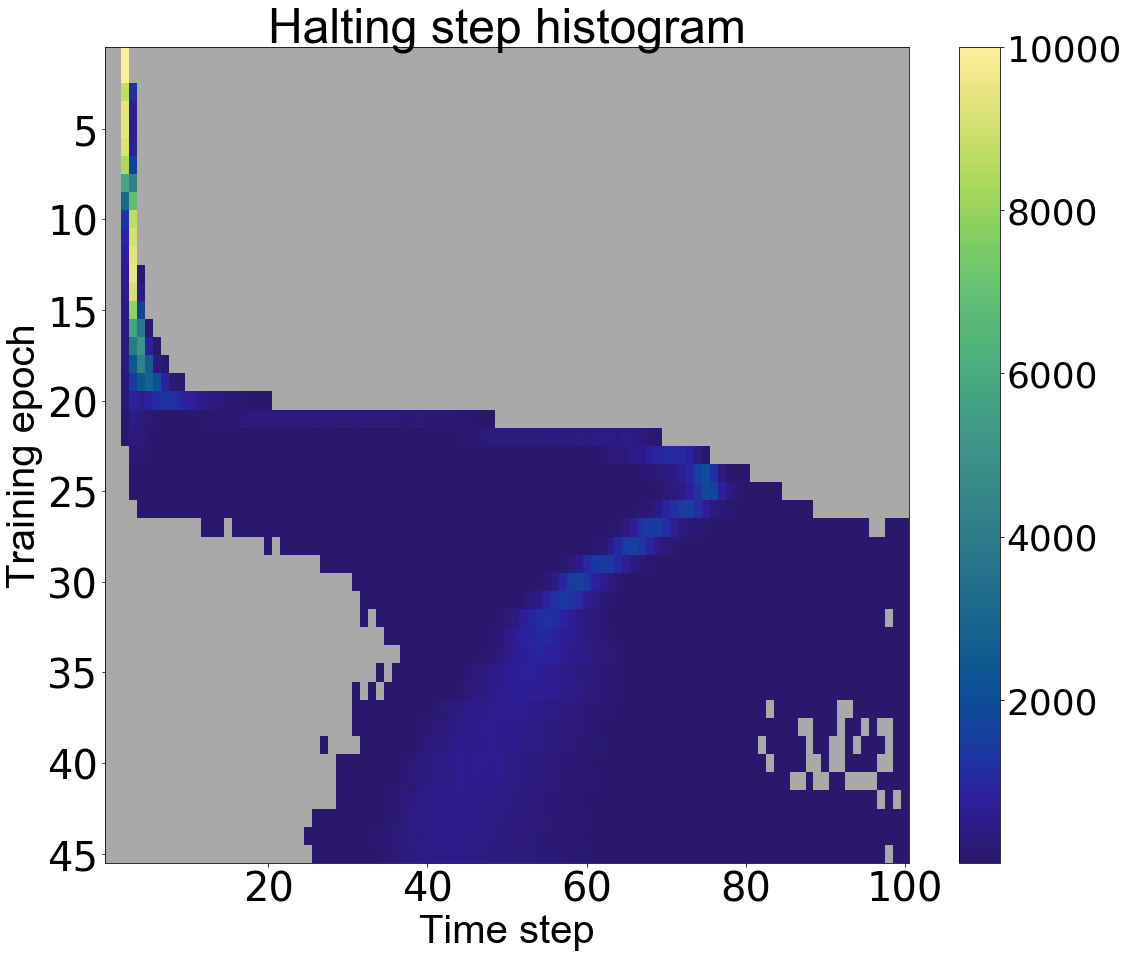

In [7]:
idx = 0

exper = experiments[idx]
if "act_sbV3.2" in exper.args.model:
    p_title="Halting step histogram"
    hyper_param = str.replace(str(exper.config.ptT_shape_param), '.', '_')
    fig_name="10dregT_mpact_train_halt_dist" + "_t{}".format(hyper_param)
else:
    p_title="Halting step histogram"
    hyper_param = str.replace(str(exper.config.tau), '.', '_')
    fig_name="10dregT_mact_train_halt_dist" + "_t{}".format(hyper_param)
    
max_epoch = None

plot_image_map_data(exper, data_set="train",  do_save=True, do_show=True,
                        data="halting_step",  
                        max_epoch=None, max_time_step=100,
                        huge=True, 
                        plot_title=p_title,
                        fig_name=fig_name)

INFO - Successfully saved fig figures/regT_mact_mean_halt_all.png


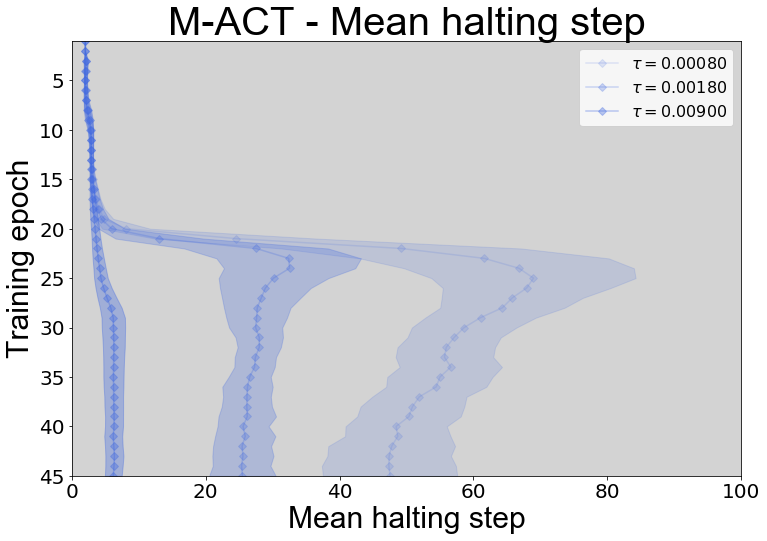

In [16]:
from utils.plots import plot_halting_step_stats

    
plot_halting_step_stats(experiments, do_show=True, do_save=True, 
                        fig_title="M-ACT - Mean halting step", fig_name="regT_mact_mean_halt_all")

In [4]:
test_funcs = RegressionWithStudentT(n_funcs=10, n_samples=10, x_dim=10, scale_p=1., shape_p=1, use_cuda=True)

In [33]:
def compute_total_stepsV1(exper, epoch_range=None, is_train=True):
    if is_train:
        keys = exper.epoch_stats["halting_step"].keys()
        halt_dict = exper.epoch_stats["halting_step"]
    else:
        keys = exper.val_stats["halting_step"].keys()
        halt_dict = exper.val_stats["halting_step"]
 
    if epoch_range is None:
        epoch_range = [keys[0], keys[-1]]

    total_steps = 0
    for key, halting_steps in halt_dict.items():

        if epoch_range[0] <= key <= epoch_range[1]:
            num_of_steps = halting_steps.shape[0]
            values = np.arange(0, num_of_steps)
            total_steps += np.sum(values * halting_steps)

    return total_steps

total_ops = 0
idx = 4
exper = experiments[idx]
new_exper = new_experiments[idx]
print(exper.args.model)
if "meta_act" in exper.args.model:
    total_ops = compute_total_stepsV1(exper, epoch_range=None)
step_losses = get_evaluation_step_loss(new_exper, steps=[1, 10, 50, 100])
print("Total steps {}".format(total_ops))
print("Step losses")
print(np.array_str(step_losses))

meta_actV1_regression_T_tau0.0018
Total steps 7296844
Step losses
[ 43.21118546  29.60560226  22.14385223  20.19882584  18.91691017]


In [27]:
idx = 2
new_exper = new_experiments[idx]
print(new_exper.args.model)
mean, std, median, _ , a_range = new_exper.get_step_dist_statistics(with_range=True)
print("[{}, {}] & {:.2f} & {:.2f} & {} ".format(a_range[0], a_range[1], round(mean,2), round(std,2), median))

meta_actV1_regression_T_tau0.009
[2, 15] & 6.63 & 1.35 & 7 


[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 65, 66, 70, 71, 79, 81, 94]
INFO - Successfully saved fig logs/run_20171002_23_12_29_meta_actV1_45ep_tau0.0018_lr5e05/qzxT_conditionals0_9982.png


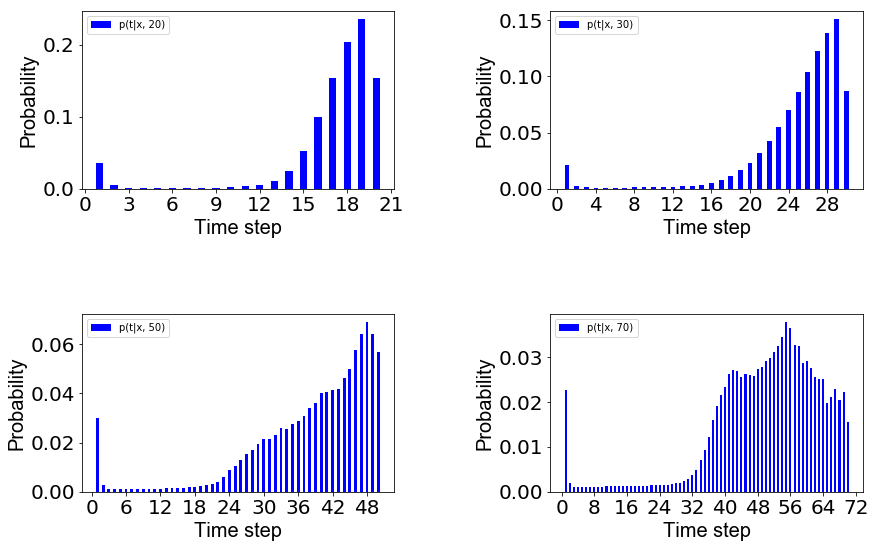

In [46]:
from utils.common import compute_mean_ptx
from pylab import MaxNLocator
from scipy.stats import geom
from utils.plots import plot_qtT_distributions

       

idx = 1

qzxT = new_experiments[idx].val_stats["qzxT"]
halt_steps = new_experiments[idx].val_stats["halting_step"][400]
ptx_T = compute_mean_ptx(qzxT, halt_steps)
# filter_horizons=np.arange(50, 60)
filter_horizons = [20, 30, 50, 70]
print(ptx_T.keys())

plot_qtT_distributions(new_experiments[idx], ptx_T, do_save=True, plot_prior=False, height=20,
                       filter_horizons=filter_horizons)

In [4]:
idx = 1
exper = experiments[1]

total_ops = compute_total_steps(exper, epoch_range=None)

print(total_ops)

7296844


In [20]:
experiments[3].generate_figures()

INFO - Successfully saved fig logs/run_20171002_17_11_24_meta_actV1_45ep_tau0.0008_lr5e05/loss_train_meta_actV1_45ep_tau0.0008.png
(100, 45)
INFO - Successfully saved fig logs/run_20171002_17_11_24_meta_actV1_45ep_tau0.0008_lr5e05/loss_optimizer_train_meta_actV1_45ep_tau0.0008.png
INFO - Successfully saved fig logs/run_20171002_17_11_24_meta_actV1_45ep_tau0.0008_lr5e05/loss_eval_meta_actV1_45ep_tau0.0008.png
(100, 45)
INFO - Successfully saved fig logs/run_20171002_17_11_24_meta_actV1_45ep_tau0.0008_lr5e05/loss_optimizer_eval_meta_actV1_45ep_tau0.0008.png
(101, 10)
INFO - Successfully saved fig logs/run_20171002_17_11_24_meta_actV1_45ep_tau0.0008_lr5e05/train_step_loss_map_meta_actV1_45ep_tau0.0008.png
INFO - Successfully saved fig logs/run_20171002_17_11_24_meta_actV1_45ep_tau0.0008_lr5e05/T_dist_train.png
INFO - Successfully saved fig logs/run_20171002_17_11_24_meta_actV1_45ep_tau0.0008_lr5e05/gradient_statistics.png
(101, 10)
INFO - Successfully saved fig logs/run_20171002_17_11_24_